In [99]:
# Importing all required packages
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from keras.layers import Dense,LSTM,Dropout,Flatten
from keras import Sequential
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error




In [100]:
# Gather the Apple data
tick = "AAPL"
df = yf.download(tick)
df.index = pd.to_datetime(df.index)

#Drop unnecessary columns, and filter data
df = df[df.index >= '2018-01-01']

# Add returns column
df['Return'] = (df['Adj Close']-df['Open'])/df['Open']

#Create copy of dataset for later use
stock_data = df.copy()
df.head(5)

[*********************100%%**********************]  1 of 1 completed
C:\Users\Matt\AppData\Local\Temp\ipykernel_10040\2809542692.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.670982,102223600,-0.043936
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.663895,118071600,-0.057233
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.852783,89738400,-0.052909
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.317905,94640000,-0.047096
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.164436,82271200,-0.055591


In [101]:
# Create both 50 and 200 day moving average
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Create trace for the candlesticks
candlestick = go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')

#Create trace for moving averages, intially set to not be visible
ma_50 = go.Scatter(x=df.index, y=df['MA50'], mode='lines', name='50-Day MA', line=dict(color='blue'), visible = False)
ma_200 = go.Scatter(x=df.index, y=df['MA200'], mode='lines', name='200-Day MA', line=dict(color='black'), visible = False)

# Create buttons to toggle moving averages
button_50 = dict(label='50-Day MA', method='update', args=[{'visible': [True, True, False]}, {'title': 'Apple Inc. (AAPL) - 50-Day MA'}])
button_200 = dict(label='200-Day MA', method='update', args=[{'visible': [True, False, True]}, {'title': 'Apple Inc. (AAPL) - 200-Day MA'}])
button_both = dict(label='Both', method='update', args=[{'visible': [True, True, True]}, {'title': 'Apple Inc. (AAPL)'}])
button_none = dict(label='None', method='update', args=[{'visible': [True, False, False, False]}, {'title': 'Apple Inc. (AAPL)'}])

# Creating button menu
updatemenus = list([
    dict(active=3,
         buttons=[button_50, button_200, button_both, button_none],
         x=1.0,
         y=1.3,
         xanchor='right',
         yanchor='top',
         pad=dict(t=0, r=10),
         showactive=True)
])

# Updating layout of figure
layout = dict(title='Apple Inc. (AAPL)',
              xaxis_title='Date',
              yaxis_title='Stock Price ($)',
              updatemenus=updatemenus)

# Create and display figure
fig = go.Figure(data=[candlestick, ma_50, ma_200], layout=layout)
fig.show()

C:\Users\Matt\AppData\Local\Temp\ipykernel_10040\4027303624.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Matt\AppData\Local\Temp\ipykernel_10040\4027303624.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



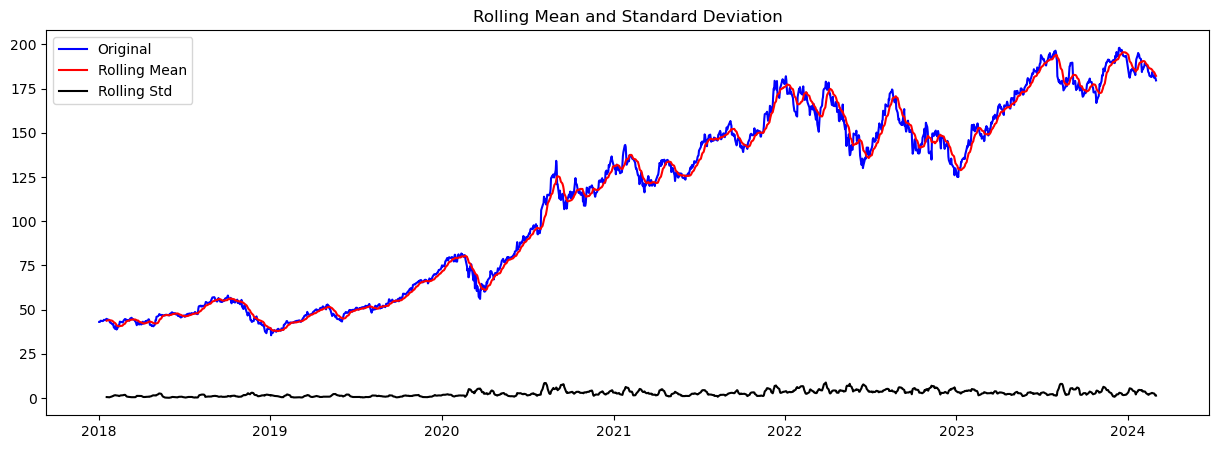

Results of dickey fuller test
Test Statistics                  -0.874181
p-value                           0.796356
No. of lags used                  0.000000
Number of observations used    1550.000000
dtype: float64


In [102]:
#Test data for staionarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean,color='red',label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output)

test_stationarity(df['Close'])    

In [103]:
# Making the data stationary
df['Stock Differencing']=df['Close']-df['Close'].shift(1)
adft = adfuller(df['Stock Differencing'].dropna(),autolag='AIC')
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
print(output)

Test Statistics                 -40.59777
p-value                           0.00000
No. of lags used                  0.00000
Number of observations used    1549.00000
dtype: float64


C:\Users\Matt\AppData\Local\Temp\ipykernel_10040\4189365159.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
# Create training and testing sets for models
stock_data.index = pd.to_datetime(stock_data.index)
df_train = stock_data[stock_data.index < '2023-02-02']
df_valid = stock_data[stock_data.index >= '2023-02-02']
train = df_train['Close'].values
test = df_valid['Close'].values
print(df_train.shape)
print(df_valid.shape)


(1280, 7)
(271, 7)


In [105]:
# Find optimal p,d,q for ARIMA model
model = auto_arima(train, start_p=0, start_q=0, test='adf', max_p=3, max_q=3,
                   m=1, d=None, seasonal=False,
                   start_P=0, D=0,
                   trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5678.364, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5676.017, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5675.738, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5678.019, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5676.483, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5676.617, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5678.378, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5675.620, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5676.521, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5676.615, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5675.872, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5678.420, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.483 seconds


In [106]:
# After finding the optimal p,d,q values, fit and create the model.

history = [x for x in train]
predictions = list()

for t in range(len(df_valid)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=145.357025, expected=150.820007
predicted=150.496348, expected=154.500000
predicted=154.278637, expected=151.729996
predicted=151.875844, expected=154.649994
predicted=154.487984, expected=151.919998
predicted=152.072792, expected=150.869995
predicted=150.941012, expected=151.009995
predicted=151.005918, expected=153.850006
predicted=153.681869, expected=153.199997
predicted=153.228553, expected=155.330002
predicted=155.205090, expected=153.710007
predicted=153.799580, expected=152.550003
predicted=152.624553, expected=148.479996
predicted=148.723499, expected=148.910004
predicted=148.899051, expected=149.399994
predicted=149.370486, expected=146.710007
predicted=146.867291, expected=147.919998
predicted=147.857362, expected=147.410004
predicted=147.436680, expected=145.309998
predicted=145.436543, expected=145.910004
predicted=145.881771, expected=151.029999
predicted=150.724313, expected=153.830002
predicted=153.654521, expected=151.600006
predicted=151.718721, expected=152

In [107]:
fig = go.Figure()
fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price", title = "Actual vs. Forecasted Closing Price of Apple (ARIMA)")
fig.add_trace(go.Scatter(x=df_valid.index,y=df_valid.Close,name='Closing Price'))
fig.add_trace(go.Scatter(x=df_valid.index,y=predictions,name='Forecasted Closing price'))
fig.show()

In [108]:
# Getting the Root Mean Squared Error of the ARIMA model
rmse_arima = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_arima)

Test RMSE: 2.173


In [109]:
# Calculating prediction inside threshold of 1%
threshold = 1

actual_prices = df_valid['Close']
percentage_changes = ((predictions - actual_prices) / actual_prices) * 100
correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)

rate_ARIMA = (correct_predictions / len(actual_prices)) * 100

print("Hit Rate: %.2f%%" % rate_ARIMA)


Hit Rate: 66.42%


In [110]:
# Pre-process data for LSTM model
# Scaling and reshaping data
training_values = np.reshape(train,(len(train),1))
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)

# Assigning training values to the training data
x_train = training_values[0:len(training_values)-1]
y_train = training_values[1:len(training_values)]
x_train = np.reshape(x_train,(len(x_train),1,1))

In [111]:
# Creating, compiling, training the model
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(None,1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=8)

Epoch 1/25
160/160 [==============================] - 3s 3ms/step - loss: 0.0322
Epoch 2/25
160/160 [==============================] - 0s 3ms/step - loss: 3.5943e-04
Epoch 3/25
160/160 [==============================] - 0s 3ms/step - loss: 3.2789e-04
Epoch 4/25
160/160 [==============================] - 0s 3ms/step - loss: 2.8776e-04
Epoch 5/25
160/160 [==============================] - 0s 3ms/step - loss: 2.8048e-04
Epoch 6/25
160/160 [==============================] - 1s 4ms/step - loss: 2.5830e-04
Epoch 7/25
160/160 [==============================] - 1s 5ms/step - loss: 2.8271e-04
Epoch 8/25
160/160 [==============================] - 1s 5ms/step - loss: 2.8209e-04
Epoch 9/25
160/160 [==============================] - 1s 5ms/step - loss: 2.9700e-04
Epoch 10/25
160/160 [==============================] - 1s 4ms/step - loss: 2.7634e-04
Epoch 11/25
160/160 [==============================] - 1s 4ms/step - loss: 3.1963e-04
Epoch 12/25
160/160 [==============================] - 1s 5ms/step 

In [112]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = np.reshape(test, (len(test), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price= np.squeeze(predicted_price)

9/9 [==============================] - 1s 2ms/step


In [113]:
# LSTM - Plotting predicted price vs. actual closing price
fig = go.Figure()
fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price", title = "Actual vs. Forecasted Closing Price of Apple (LSTM)")
fig.add_trace(go.Scatter(x=df_valid.index,y=df_valid.Close,name='Closing Price'))
fig.add_trace(go.Scatter(x=df_valid.index,y=predicted_price,name='Forecasted Closing price'))
fig.show()

In [114]:
# Getting the Root Mean Squared Error of the LSTM model
rmse_lstm = math.sqrt(mean_squared_error(test, predicted_price))
print('Test MSE: %.3f' % rmse_lstm)

Test MSE: 1.018


In [115]:
# Calculating prediction inside threshold of 1%
threshold = 1

actual_prices = df_valid['Close']
percentage_changes = ((predicted_price - actual_prices) / actual_prices) * 100
correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)

rate_LSTM = (correct_predictions / len(actual_prices)) * 100

print("Hit Rate: %.2f%%" % rate_LSTM)


Hit Rate: 98.89%


In [116]:
# Display the results of the models
model_table = {'ARIMA': [rmse_arima, rate_ARIMA],
        'LSTM': [rmse_lstm, rate_LSTM]}

comparison = pd.DataFrame(model_table, index=['RMSE', 'Rate'])

print(comparison)

          ARIMA       LSTM
RMSE   2.173308   1.018174
Rate  66.420664  98.892989
